In [1]:
from owslib.wfs import WebFeatureService
import geopandas as gpd
import numpy as np
from pyproj import Transformer
import requests
from io import BytesIO
import geojson
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
from shapely.geometry import box, Point, LineString, MultiLineString
import networkx as nx
import random
from collections import Counter

In [2]:
import warnings
warnings.simplefilter("ignore")

# Download hiking trails data
From WFS service: https://geoportale.regione.emilia-romagna.it/servizi/servizi-ogc/wfs/service-2

In [3]:
# Connect to WFS
wfs_url = 'http://servizigis.regione.emilia-romagna.it/wfs/rete_escursionistica'
wfs = WebFeatureService(wfs_url, version='2.0.0')

In [4]:
# View available data
wfs.contents

{'portale_rete_escursionistica:Rifugio_gestito': <owslib.feature.wfs200.ContentMetadata at 0x118dca110>,
 'portale_rete_escursionistica:Bivacco': <owslib.feature.wfs200.ContentMetadata at 0x118dca290>,
 'portale_rete_escursionistica:Rifugio_non_gestito': <owslib.feature.wfs200.ContentMetadata at 0x118dca260>,
 'portale_rete_escursionistica:Ricovero_di_emergenza': <owslib.feature.wfs200.ContentMetadata at 0x118dca1d0>,
 'portale_rete_escursionistica:Punti_di_soccorso_alpino': <owslib.feature.wfs200.ContentMetadata at 0x118dca140>,
 'portale_rete_escursionistica:Emergenza_antropico_ambientale': <owslib.feature.wfs200.ContentMetadata at 0x118dca0b0>,
 'portale_rete_escursionistica:Sorgente_o_fontana': <owslib.feature.wfs200.ContentMetadata at 0x118dca020>,
 'portale_rete_escursionistica:Limitazione_al_transito': <owslib.feature.wfs200.ContentMetadata at 0x118dc9f90>,
 'portale_rete_escursionistica:Punto_panoramico_a_360_gradi': <owslib.feature.wfs200.ContentMetadata at 0x118dc9f00>,
 'por

In [5]:
# Check operations
[operation.name for operation in wfs.operations]

['GetCapabilities',
 'DescribeFeatureType',
 'GetPropertyValue',
 'GetFeature',
 'GetGmlObject',
 'ListStoredQueries',
 'DescribeStoredQueries',
 'ImplementsBasicWFS',
 'ImplementsTransactionalWFS',
 'ImplementsLockingWFS',
 'KVPEncoding',
 'XMLEncoding',
 'SOAPEncoding',
 'ImplementsInheritance',
 'ImplementsRemoteResolve',
 'ImplementsResultPaging',
 'ImplementsStandardJoins',
 'ImplementsSpatialJoins',
 'ImplementsTemporalJoins',
 'ImplementsFeatureVersioning',
 'ManageStoredQueries',
 'CountDefault']

## Request data
NB: this data is in a different CRS (EPSG::25832) and datum (ETRS89 / UTM zone 32N) ! 
The DEM and mountain peaks were in two differerent CRS, but same datum (WGS84)

In [6]:
layer = 'portale_rete_escursionistica:Percorso_escursionistico'

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typeName": layer,
    "outputFormat": "GEOJSON"  
}

response = requests.get(wfs_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    try:
        gdf = gpd.read_file(BytesIO(response.content))
        print("GeoDataFrame loaded successfully")
        print(gdf.head())
    except Exception as e:
        print(f"Error loading GeoDataFrame: {e}")
else:
    print(f"Error fetching WFS data: {response.status_code}")

GeoDataFrame loaded successfully
                        GmlID  OBJECTID                           ID_PERCORSO  \
0  Percorso_escursionistico.1         1  000424EF-3F1A-4855-B836-6AFE57DB9C01   
1  Percorso_escursionistico.2         2  0018f6b2-6929-448b-b19a-81bf41aedd2e   
2  Percorso_escursionistico.3         3  00642E80-03D0-4876-A1C2-5AC47185A6C6   
3  Percorso_escursionistico.4         4  006AB7C0-E14F-4C2E-8CB6-36AE847D4421   
4  Percorso_escursionistico.5         5  00813463-27C6-4562-9D3F-17F968E55788   

                                      LOCALITA_          DIFFICOLTA_  \
0           Fonti Di Poiano - Peschiera Zamboni  E - Escursionistico   
1     Capanna del Braiola - Capanna del Braiola  E - Escursionistico   
2                   Percorso 906 - Percorso 920        T - Turistico   
3                 Strada Tagliole - Percorso 00  E - Escursionistico   
4   Sentiero Romea Strata -Via Romea Longobarda  E - Escursionistico   

  NOME_NUMERO      SIGLA  DISLIVELLO_SALITA  DI

In [7]:
# save it to a file
output_file = '../data/hiking_trails.geojson'
with open(output_file, 'wb') as f:
    f.write(response.content)
print(f"Coverage saved to {output_file}")

Coverage saved to ../data/hiking_trails.geojson


# Data Exploration (unclipped dataset)

In [8]:
trails_path = '../data/hiking_trails.geojson'
trails_gdf = gpd.read_file(trails_path)
trails_gdf.head(5)

GmlID  OBJECTID                           ID_PERCORSO  \
0  Percorso_escursionistico.1         1  000424EF-3F1A-4855-B836-6AFE57DB9C01   
1  Percorso_escursionistico.2         2  0018f6b2-6929-448b-b19a-81bf41aedd2e   
2  Percorso_escursionistico.3         3  00642E80-03D0-4876-A1C2-5AC47185A6C6   
3  Percorso_escursionistico.4         4  006AB7C0-E14F-4C2E-8CB6-36AE847D4421   
4  Percorso_escursionistico.5         5  00813463-27C6-4562-9D3F-17F968E55788   

                                      LOCALITA_          DIFFICOLTA_  \
0           Fonti Di Poiano - Peschiera Zamboni  E - Escursionistico   
1     Capanna del Braiola - Capanna del Braiola  E - Escursionistico   
2                   Percorso 906 - Percorso 920        T - Turistico   
3                 Strada Tagliole - Percorso 00  E - Escursionistico   
4   Sentiero Romea Strata -Via Romea Longobarda  E - Escursionistico   

  NOME_NUMERO      SIGLA  DISLIVELLO_SALITA  DISLIVELLO_DISCESA  LUNGHEZZA  \
0         621     RE-621             2491.0              1767.0    25263.0   
1      727VAR    PR-727R               10.0                 6.0       96.0   
2        906a    BO-906a                9.0                 2.0      151.0   
3         517     MO-517              589.0                67.0     4289.0   
4          14  VRLMO-014             1027.0               357.0    10282.0   

             GESTORE                                  SEGNAVIA  \
0  CAI REGGIO EMILIA                                       CAI   
1          CAI PARMA         727V su bandierina bianca e rossa   
2        CAI BOLOGNA                                       CAI   
3         CAI MODENA                                       CAI   
4                 ND  Logo Romea Strata - Via Romea Longobarda   

         ALTRO_SEGNAVIA TEMPO_ANDATA TEMPO_RITORNO CARRABILITA___  \
0                              11:00         10:00                  
1                  null        00:05         00:05           null   
2                  null        00:05         00:05           null   
3  CERCHIO BIANCO-ROSSO        02:30         01:45           null   
4                  null        05:15         04:15           null   

                         LINK  \
0                               
1             www.caiparma.it   
2                        null   
3                        null   
4  http://www.romeastrata.it/   

                                   LINK_GOOGLE_EARTH  \
0  https://servizigis.regione.emilia-romagna.it/g...   
1  https://servizigis.regione.emilia-romagna.it/g...   
2  https://servizigis.regione.emilia-romagna.it/g...   
3  https://servizigis.regione.emilia-romagna.it/g...   
4  https://servizigis.regione.emilia-romagna.it/g...   

                                            geometry  
0  MULTILINESTRING ((10.42250 44.30361, 10.42243 ...  
1  MULTILINESTRING ((9.99598 44.40378, 9.99595 44...  
2  MULTILINESTRING ((11.30551 44.44471, 11.30550 ...  
3  MULTILINESTRING ((10.60306 44.12339, 10.60298 ...  
4  MULTILINESTRING ((10.77517 44.15149, 10.77552 ...

In [9]:
# Check columns types
trails_gdf.dtypes

GmlID                   object
OBJECTID                 int64
ID_PERCORSO             object
LOCALITA_               object
DIFFICOLTA_             object
NOME_NUMERO             object
SIGLA                   object
DISLIVELLO_SALITA      float64
DISLIVELLO_DISCESA     float64
LUNGHEZZA              float64
GESTORE                 object
SEGNAVIA                object
ALTRO_SEGNAVIA          object
TEMPO_ANDATA            object
TEMPO_RITORNO           object
CARRABILITA___          object
LINK                    object
LINK_GOOGLE_EARTH       object
geometry              geometry
dtype: object

In [10]:
# How many trails?
len(trails_gdf)

2230

In [11]:
# What is the CRS?
trails_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# Check total bounds of geodataframe
trails_gdf.total_bounds

array([ 9.19319308, 43.6608323 , 12.720554  , 45.1554895 ])

<Axes: >

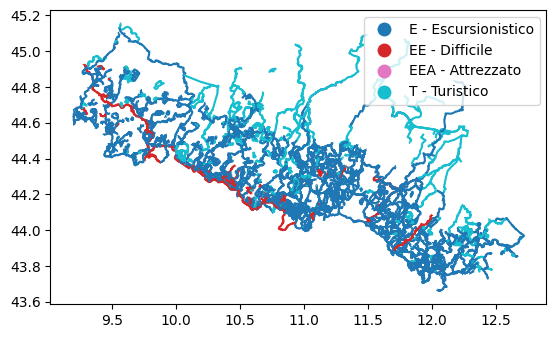

In [13]:
trails_gdf.plot(column='DIFFICOLTA_', legend=True)

# Preprocessing: trails data
The request above returns all trails in Emilia Romagna, whereas I am only interested in the trails of the study area.
So I need to clip the trails to fit the DEM (already cropped on the study area) and make sure they are in the same projection (the one of the DEM, which is in meters).

Clipping makes sure that the trail parts outside of the DEM bounds are left out, while the parts inside are kept.

In [15]:
dem_path = '../data/tinitaly_dem.tif'
with rasterio.open(dem_path) as src:
    dem_bounds = src.bounds
    dem_crs = src.crs
    dem_transform = src.transform
    dem_data = src.read(1)

dem_bbox = box(dem_bounds.left, dem_bounds.bottom, dem_bounds.right, dem_bounds.top)

# Create a GeoDataFrame with the DEM bounding box
dem_bbox_gdf = gpd.GeoDataFrame([[dem_bbox]], columns=['geometry'], crs=dem_crs)

# Set in the same projection
if trails_gdf.crs != dem_crs:
    trails_gdf = trails_gdf.to_crs(dem_crs)
    
# Clip the trail network using the DEM bounding box
clipped_trails = gpd.clip(trails_gdf, dem_bbox_gdf)

In [16]:
print(dem_bbox)

POLYGON ((627220.0394198465 4890733.6200815, 627220.0394198465 4931729.341482854, 571898.9306857754 4931729.341482854, 571898.9306857754 4890733.6200815, 627220.0394198465 4890733.6200815))


In [17]:
clipped_trails.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 347 entries, 854 to 1805
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   GmlID               347 non-null    object  
 1   OBJECTID            347 non-null    int64   
 2   ID_PERCORSO         347 non-null    object  
 3   LOCALITA_           347 non-null    object  
 4   DIFFICOLTA_         347 non-null    object  
 5   NOME_NUMERO         347 non-null    object  
 6   SIGLA               347 non-null    object  
 7   DISLIVELLO_SALITA   347 non-null    float64 
 8   DISLIVELLO_DISCESA  347 non-null    float64 
 9   LUNGHEZZA           347 non-null    float64 
 10  GESTORE             347 non-null    object  
 11  SEGNAVIA            347 non-null    object  
 12  ALTRO_SEGNAVIA      347 non-null    object  
 13  TEMPO_ANDATA        347 non-null    object  
 14  TEMPO_RITORNO       347 non-null    object  
 15  CARRABILITA___      347 non-null  

In [18]:
clipped_trails.explore()

`Clipped_trails` will be the working dataset from now on

## Geometry type: Multilinestring
A multilinestring is a collection of linestrings, determined by various points between a start-point and end-point.

MultiLineString


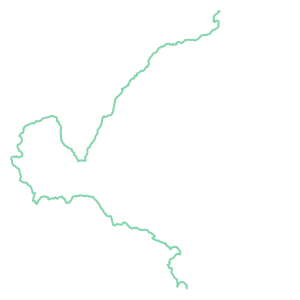

In [19]:
# View geometry type: MULTILINESTRING
print(trails_gdf.loc[0]['geometry'].geom_type)
trails_gdf.loc[0]['geometry']

How to access coordinates of a Multilinestring

In [20]:
# Each part of a Multilinestring is a Linestring
trail = trails_gdf.loc[0]
print(type(trail['geometry'].geoms[0]))
# Check how many parts
print(f"Number of Linestrings inside: {len(trail['geometry'].geoms)}")

# Can access the coordinates of each part using .coords
coords = list(trail['geometry'].geoms[0].coords)
print(f"Number of points inside: {len(coords)}")

<class 'shapely.geometry.linestring.LineString'>
Number of Linestrings inside: 1
Number of points inside: 1520


Plot trails on DEM and peaks

## Data Exploration

In [21]:
len(clipped_trails)

347

In [22]:
clipped_trails.head(5)

GmlID  OBJECTID  \
854    Percorso_escursionistico.902       902   
2054  Percorso_escursionistico.2155      2155   
1479  Percorso_escursionistico.1551      1551   
181    Percorso_escursionistico.188       188   
1682  Percorso_escursionistico.1762      1762   

                               ID_PERCORSO  \
854   6AC706B5-8FCB-4D3E-93D0-33D3A367BF48   
2054  F92D6990-CB05-4C3F-BCC2-5D8A6D67CD2E   
1479  B40AF5BA-7E5E-4308-AC78-2555EF127632   
181   16BF6C2D-98BE-474F-BAB6-AC7CB6F42622   
1682  CC6B301D-C519-4A63-98C1-96DC32C30B88   

                                     LOCALITA_          DIFFICOLTA_  \
854           Ponte Sant'Anna - Colle Bruciata  E - Escursionistico   
2054              Vacchereccie - Passo Boccaia       EE - Difficile   
1479           Ponte Sant'Anna - Passo Boccaia  E - Escursionistico   
181               Ponte Sant'Ana - Percorso 00  E - Escursionistico   
1682   Passo Del Saltello - Passo Del Saltello  E - Escursionistico   

     NOME_NUMERO   SIGLA  DISLIVELLO_SALITA  DISLIVELLO_DISCESA  LUNGHEZZA  \
854          543  MO-543              886.0               142.0     8124.0   
2054         539  MO-539              747.0               289.0     5866.0   
1479         541  MO-541              706.0                99.0     6337.0   
181          549  MO-549              801.0                77.0     7492.0   
1682          22   LU-22                0.0                 6.0       98.0   

         GESTORE SEGNAVIA                                     ALTRO_SEGNAVIA  \
854   CAI MODENA      CAI    CERCHIO ARANCIONE ITINERARIO PARCO DEL FRIGNANO   
2054  CAI MODENA      CAI                               CERCHIO BIANCO-ROSSO   
1479  CAI MODENA      CAI  CERCHIO BIANCO-ARANCIO ITINERARIO FAUNISTICO D...   
181   CAI MODENA      CAI    CERCHIO ARANCIONE ITINERARIO PARCO DEL FRIGNANO   
1682   CAI LUCCA      CAI                                               null   

     TEMPO_ANDATA TEMPO_RITORNO CARRABILITA___  LINK  \
854         04:15         03:30           null  null   
2054        03:15         02:45           null  null   
1479        03:00         02:15           null  null   
181         03:45         03:00           null  null   
1682         null          null           null  null   

                                      LINK_GOOGLE_EARTH  \
854   https://servizigis.regione.emilia-romagna.it/g...   
2054  https://servizigis.regione.emilia-romagna.it/g...   
1479  https://servizigis.regione.emilia-romagna.it/g...   
181   https://servizigis.regione.emilia-romagna.it/g...   
1682  https://servizigis.regione.emilia-romagna.it/g...   

                                               geometry  
854   LINESTRING (625127.584 4893764.893, 625121.205...  
2054  LINESTRING (625351.346 4893455.425, 625352.886...  
1479  LINESTRING (625127.584 4893764.893, 625121.205...  
181   MULTILINESTRING ((625127.584 4893764.893, 6251...  
1682  LINESTRING (621595.710 4891186.255, 621594.256...

Trail lenght

In [23]:
# Which is the average trail length?
# Create length column using the .length geometry method
clipped_trails['length'] = clipped_trails.length

avg_length = clipped_trails['length'].mean() # [m]
print(f'Average trail length: {avg_length*0.001:.2f} km') 

Average trail length: 5.45 km


In [24]:
# Which is the longest trail ? Use the length column created earlier
longest_trail = clipped_trails.loc[clipped_trails['length'].idxmax()]
print(f"Longest trail is {longest_trail['NOME_NUMERO']}: {longest_trail['length']*0.001:.2f} km ({longest_trail['LOCALITA_']})")

Longest trail is 00: 89.64 km (Passo Dei Due Santi - Poggio Delle Ignude)


Trail elevation gain

In [25]:
# Same function used in dem_and_peaks.ipynb
def extract_elevation(point, dem_data, dem_transform):
    ''' Function to get elevation for a given point from DEM '''

    # Transform the point coordinates to the DEM's array indices
    row, col = rasterio.transform.rowcol(dem_transform, point.x, point.y)
    
    # Check if the indices are within the bounds of the DEM array
    if 0 <= row < dem_data.shape[0] and 0 <= col < dem_data.shape[1]:
        # Extract the elevation value at the point
        elevation = round(float(dem_data[row, col]),1)
    else:
        # Handle points outside the DEM bounds (set to NaN or another value)
        elevation = np.nan
    return elevation

In [26]:
def calculate_elevation_gain(elevations):
    ''' Computes elevation gain as the sum of positive differences between consecutive elevations '''
    if len(elevations) == 0:
        return 0
    gain = np.sum(np.diff(elevations)[np.diff(elevations) > 0])
    return gain

In [27]:
# Sample elevations and calculate elevation gain for each trail
elevations_list = []
elevation_gains = []

for geom in clipped_trails['geometry']:
    coords = []
    if geom.geom_type == 'LineString':
        coords = list(geom.coords)
    elif geom.geom_type == 'MultiLineString':
        coords = list(geom.geoms[0].coords)

    elevations = [extract_elevation(Point(x, y), dem_data, dem_transform) for x, y in coords]
    elevations_list.append(elevations)
    elevation_gains.append(calculate_elevation_gain(elevations))

# Add the results to the GeoDataFrame
clipped_trails['elevations'] = elevations_list
clipped_trails['elevation_gain'] = elevation_gains

# Find the trail with the highest elevation gain
max_elegain = clipped_trails.loc[clipped_trails['elevation_gain'].idxmax()]
print(f"Trail with max elevation gain is {max_elegain['NOME_NUMERO']}: +{max_elegain['elevation_gain']:.2f}m ({max_elegain['LOCALITA_']})")

Trail with max elevation gain is 00: +7982.30m (Passo Dei Due Santi - Poggio Delle Ignude)


In [28]:
# Which is the average elevation gain?
avg_elegain = clipped_trails['elevation_gain'].mean()
print(f'Average elevation gain: +{avg_elegain:.2f} m') 

Average elevation gain: +420.28 m


Trail slope

In [29]:
# Which is the trail with the highest slope? (elevation gain per km)
# Pendenza (%) = [ Dislivello (m) / Lunghezza Percorso (m) ] * 100 
clipped_trails['pendenza'] = clipped_trails['elevation_gain'] / clipped_trails['length'] * 100

# Exclude sentieri attrezzati (ferrate)
no_ferr = clipped_trails.loc[clipped_trails['DIFFICOLTA_'] != 'EEA - Attrezzato']
max_pend =  no_ferr.loc[no_ferr['pendenza'].idxmax()]
print(f"Trail with max slope is {max_pend['NOME_NUMERO']}: {max_pend['pendenza']:.2f} % ({max_pend['LOCALITA_']})")

Trail with max slope is 120: 64.02 % ( Passo Delle Guadine - Passo Delle Guadine)


In [30]:
max_pend

GmlID                                     Percorso_escursionistico.1314
OBJECTID                                                           1314
ID_PERCORSO                        9B0DEEA9-E446-465E-9B21-3FA954358A8B
LOCALITA_                     Passo Delle Guadine - Passo Delle Guadine
DIFFICOLTA_                                         E - Escursionistico
NOME_NUMERO                                                         120
SIGLA                                                             MS-20
DISLIVELLO_SALITA                                                  76.0
DISLIVELLO_DISCESA                                                  0.0
LUNGHEZZA                                                         164.0
GESTORE                                                       CAI MASSA
SEGNAVIA                                                            CAI
ALTRO_SEGNAVIA                                                     null
TEMPO_ANDATA                                                    

Plot DEM, peaks & trails

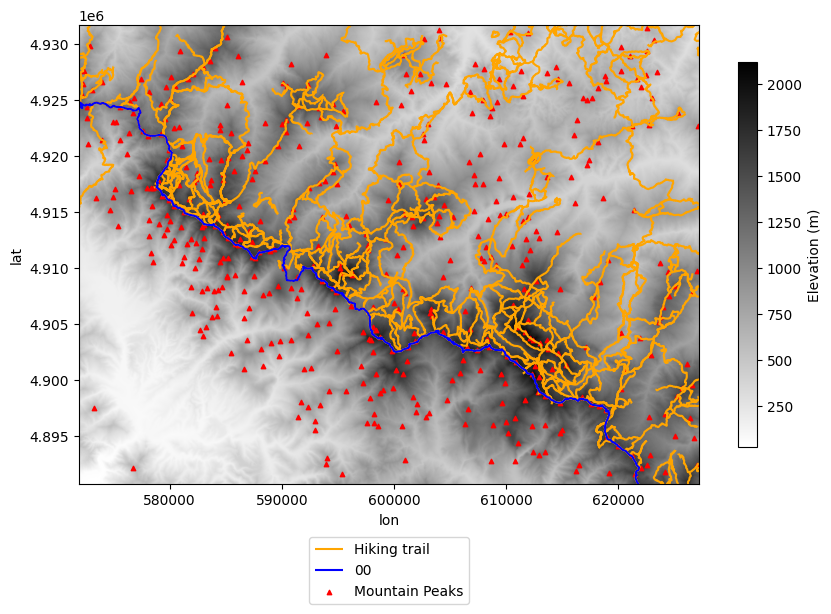

In [32]:
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)

peaks_path = '../data/peaks_clean.geojson'
peaks_clean = gpd.read_file(peaks_path)

# Plot the DEM
plt.figure(figsize=(10, 10))
plt.imshow(dem_data, cmap='binary', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
plt.colorbar(label='Elevation (m)', shrink=0.5)

# Plot hiking trails
clipped_trails.plot(ax=plt.gca(), color='orange', label='Hiking trail')
gpd.GeoSeries(longest_trail['geometry']).plot(ax=plt.gca(), color="blue", label=f"{longest_trail['NOME_NUMERO']}")

# Plot mountain peaks on top of the DEM
peaks_clean.plot(ax=plt.gca(), color='red', marker='^', markersize=10, label='Mountain Peaks')

#plt.title('Appennino Tosco-Emiliano')
plt.xlabel('lon')
plt.ylabel('lat')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.show()

# Trail Network Analysis

### 1. Create trail network (grap `G`)

In [33]:
def multilinestring_to_edges(geometry):
    ''' 
    Converts multilinestring into a list of edges, each represented as a tuple of coordinate pairs.
    
    '''

    edges = []
    if isinstance(geometry, MultiLineString):
        for linestring in geometry.geoms:
            coords = list(linestring.coords)
            for i in range(len(coords) - 1):
                edges.append((coords[i], coords[i+1]))

    elif isinstance(geometry, LineString):
        coords = list(geometry.coords)
        for i in range(len(coords) - 1):
            edges.append((coords[i], coords[i+1]))
    return edges

# Empty graph
G = nx.Graph()

# Add edges to the graph (with length and trail_id)
for idx, row in clipped_trails.iterrows():
    edges = multilinestring_to_edges(row.geometry)
    for edge in edges:
        start = edge[0]
        end = edge[1]
        trail_id = row['ID_PERCORSO']
        trail_num = row['NOME_NUMERO']
        G.add_edge(start, end, length=Point(start).distance(Point(end)), idx=idx, trail_id=trail_id, trail_num=trail_num)

print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

Number of nodes: 81170
Number of edges: 81462


In [34]:
type(G)

networkx.classes.graph.Graph

In [35]:
# Check graph structure
node = (580986.3089806027, 4915306.004504453) # example node
edges = G.edges(node, data=True)
print(type(edges))
print(edges)

<class 'networkx.classes.reportviews.EdgeDataView'>
[((580986.3089806027, 4915306.004504453), (580974.5203571303, 4915311.001766655), {'length': 12.804072511531132, 'idx': 1678, 'trail_id': 'CBFBAF97-E85D-49B1-84FF-BD3581356694', 'trail_num': '00'}), ((580986.3089806027, 4915306.004504453), (581004.1187046018, 4915299.848893736), {'length': 18.84350849057245, 'idx': 1143, 'trail_id': '8CF4B509-6E68-4A5A-9C8A-6A928E0D1A56', 'trail_num': '2'}), ((580986.3089806027, 4915306.004504453), (580966.9816126822, 4915321.473126853), {'length': 24.755311140636838, 'idx': 292, 'trail_id': '224F3D9B-6127-4243-A868-100EA84D578C', 'trail_num': '719'}), ((580986.3089806027, 4915306.004504453), (580989.5102586199, 4915299.750836121), {'length': 7.025421592780606, 'idx': 1247, 'trail_id': '9B0DEEA9-E446-465E-9B21-3FA954358A8B', 'trail_num': '120'}), ((580986.3089806027, 4915306.004504453), (580989.1495127324, 4915314.627246997), {'length': 9.07856330919137, 'idx': 285, 'trail_id': '21907A6D-8A4F-4A45-BC9

### 2. Plot trails network

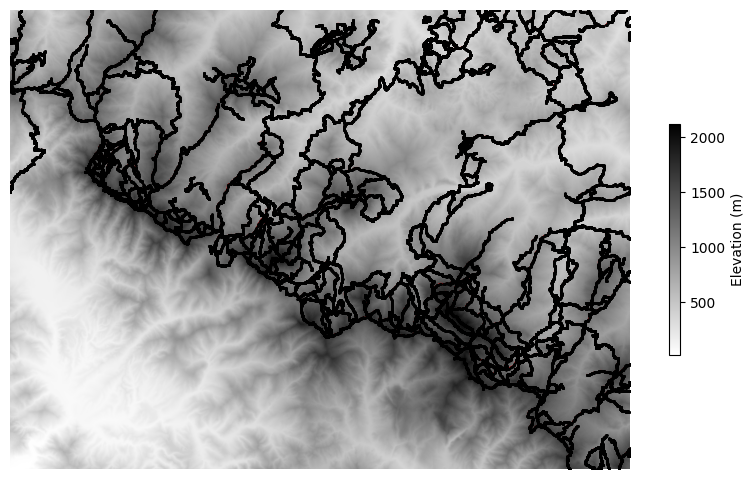

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

pos = {node: node for node in G.nodes()}  # Position nodes using their coordinates
nx.draw(G, pos, node_size=1, edge_color='red', node_color='black', with_labels=False, ax=ax)

# Optional, plot DEM
with rasterio.open('../data/tinitaly_dem.tif') as src:
    plt.imshow(src.read(1), cmap='binary', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='Elevation (m)', shrink=0.5)

plt.show()

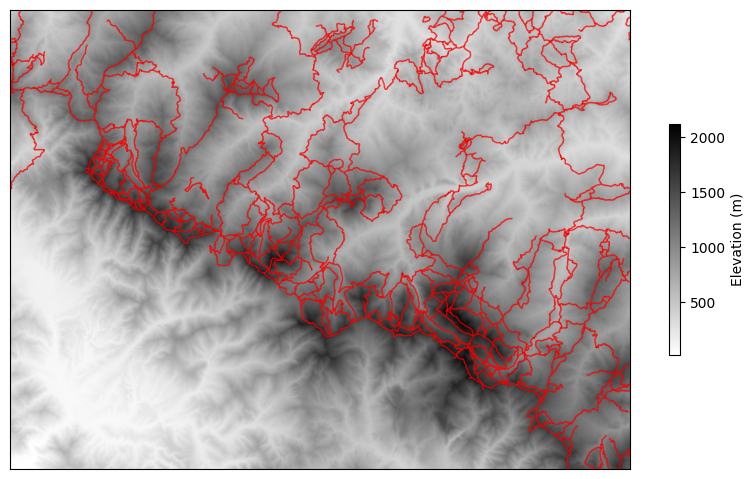

In [37]:
# Extract and plot only edges
fig, ax = plt.subplots(figsize=(10, 6))

pos = {node: node for node in G.nodes()}  # Position nodes using their coordinates
edges = G.edges()
nx.draw_networkx_edges(G, pos, edgelist=edges, ax=ax, edge_color='red')

with rasterio.open('../data/tinitaly_dem.tif') as src:
    plt.imshow(src.read(1), cmap='binary', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    plt.colorbar(label='Elevation (m)', shrink=0.5)

plt.show()

### 3. Graph analysis
1. How many intersections are there?
2. Which are the points where the most trails intersect?

In [38]:
# Count intersections: nodes with degree>1
intersections_count = sum(1 for node, degree in G.degree() if degree > 1)
print(f"Number of intersections: {intersections_count}")

Number of intersections: 81023


In [39]:
# Find nodes with most intersections
# Get the degree of each node
node_degrees = dict(G.degree())
# Find the maximum degree
max_degree = max(node_degrees.values())
# Find all nodes with this maximum degree & max degree -1 (to include more nodes)
nodes_with_max_intersections = [node for node, degree in node_degrees.items() if degree in[max_degree, max_degree-1]]

print(f"Nodes with the most intersections: {nodes_with_max_intersections}")
print(f"Maximum number of intersections: {max_degree}")

Nodes with the most intersections: [(609882.0109465416, 4902529.298172017), (580986.3089806027, 4915306.004504453), (572149.9665403129, 4926735.297680784)]
Maximum number of intersections: 6


In [40]:
# Determine which trails intersect at each intersection node
def trails_intersecting_at_node(node):
    ''' Selects only edges connected to the specified node, then creates a set of the trail_ids of the edges '''
    edges = G.edges(node, data=True)
    trail_ids = set()
    for edge in edges:
        trail_ids.add((edge[2]['idx'], edge[2]['trail_id'], edge[2]['trail_num']))
    return trail_ids

for node in nodes_with_max_intersections:
    intersecting_trails = trails_intersecting_at_node(node)
    print(f"Node {node} intersects the following trails: {intersecting_trails}")

Node (609882.0109465416, 4902529.298172017) intersects the following trails: {(1480, 'B40BF2FE-A3F7-4E4A-9128-85DE62F53A90', 'SSP'), (685, '55CF745F-50F1-4DF4-8796-04C5883E2E8A', '74'), (1678, 'CBFBAF97-E85D-49B1-84FF-BD3581356694', '00')}
Node (580986.3089806027, 4915306.004504453) intersects the following trails: {(1143, '8CF4B509-6E68-4A5A-9C8A-6A928E0D1A56', '2'), (292, '224F3D9B-6127-4243-A868-100EA84D578C', '719'), (285, '21907A6D-8A4F-4A45-BC91-AAA60E7447D7', '719B'), (1247, '9B0DEEA9-E446-465E-9B21-3FA954358A8B', '120'), (1678, 'CBFBAF97-E85D-49B1-84FF-BD3581356694', '00')}
Node (572149.9665403129, 4926735.297680784) intersects the following trails: {(1427, 'AD7DED48-2DB0-4AE9-80E6-9392B56B7268', '833'), (608, '4B2B8F02-193A-4F6D-8854-7FF7E5505B1D', '833A'), (1117, '8A90F6A0-AECF-483E-AF78-5B31AC7CC617', '837')}


Plot intersection points & trails

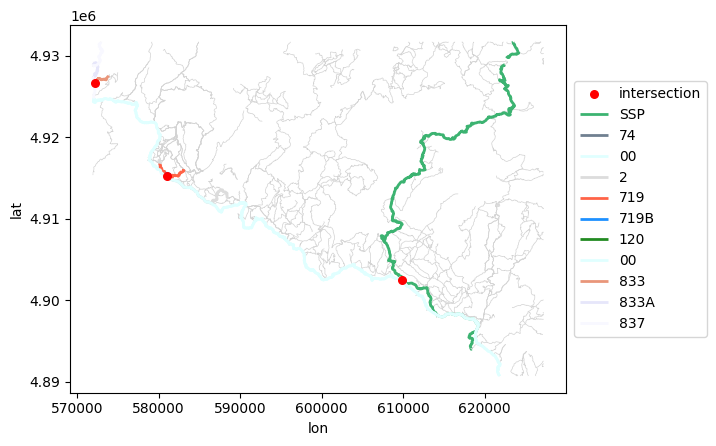

In [41]:
# Convert the nodes with max intersections to GeoDataFrame for visualization
intersections_gdf = gpd.GeoDataFrame(
    geometry=[Point(node) for node in nodes_with_max_intersections],
    crs=clipped_trails.crs
)

# Plot the graph and intersections
fig, ax = plt.subplots()

# Generate a list of unique colors and assign a unique color to each trail
colors = list(mcolors.CSS4_COLORS.keys())
random.shuffle(colors)
trail_colors = {idx: colors[i % len(colors)] for i, idx in enumerate(clipped_trails.index)}

clipped_trails.plot(ax=ax, zorder=1, color='lightgray', linewidth=0.5)
intersections_gdf.plot(ax=ax, zorder=2, color='red', markersize=30, marker='o', label='intersection')
# Highlight trails intersecting at nodes with the most intersections
for node in nodes_with_max_intersections:
    intersecting_trails = trails_intersecting_at_node(node)
    for idx, trail_id, trail_num in intersecting_trails:
        trail = clipped_trails.loc[clipped_trails['NOME_NUMERO'] == trail_num].geometry
        trail.plot(ax=ax, zorder=1, color=trail_colors[idx], linewidth=2, label=f'{trail_num}')

#ax.set_title("Main Intersection Points")
ax.set_xlabel("lon")
ax.set_ylabel("lat")
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.5), ncol=1)
plt.show()

# Request punti panoramici data
The WFS service used offers layers with panoramic viewpoints in different directions. I will download and combine them in a single request, keeping track of the source layer with a new column.

In [43]:
wfs_url = 'http://servizigis.regione.emilia-romagna.it/wfs/rete_escursionistica'
wfs = WebFeatureService(wfs_url, version='2.0.0')
wfs.contents

{'portale_rete_escursionistica:Rifugio_gestito': <owslib.feature.wfs200.ContentMetadata at 0x129cfca60>,
 'portale_rete_escursionistica:Bivacco': <owslib.feature.wfs200.ContentMetadata at 0x129cfc910>,
 'portale_rete_escursionistica:Rifugio_non_gestito': <owslib.feature.wfs200.ContentMetadata at 0x129cfcac0>,
 'portale_rete_escursionistica:Ricovero_di_emergenza': <owslib.feature.wfs200.ContentMetadata at 0x129cffd90>,
 'portale_rete_escursionistica:Punti_di_soccorso_alpino': <owslib.feature.wfs200.ContentMetadata at 0x129cffe20>,
 'portale_rete_escursionistica:Emergenza_antropico_ambientale': <owslib.feature.wfs200.ContentMetadata at 0x129cff8e0>,
 'portale_rete_escursionistica:Sorgente_o_fontana': <owslib.feature.wfs200.ContentMetadata at 0x129cfc0d0>,
 'portale_rete_escursionistica:Limitazione_al_transito': <owslib.feature.wfs200.ContentMetadata at 0x129cfe650>,
 'portale_rete_escursionistica:Punto_panoramico_a_360_gradi': <owslib.feature.wfs200.ContentMetadata at 0x129cfca00>,
 'por

In [45]:
layers = list(wfs.contents)[8:13]

# Initialize a GeoJSON feature collection
combined_geojson = {
    "type": "FeatureCollection",
    "features": []
}

for layer in layers:
    params = {
        "service": "WFS",
        "version": "2.0.0",
        "request": "GetFeature",
        "typeName": layer,
        "outputFormat": "GEOJSON"
    }
    
    response = requests.get(wfs_url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        features = response.json()
        # Add the 'layer' property to each feature
        if 'features' in features:
            for feature in features['features']:
                feature['properties']['layer'] = layer.split(':')[-1]
            # Append features to the combined GeoJSON
            combined_geojson['features'].extend(features['features'])
        else:
            print(f"No features found in the response for layer {layer}")
    else:
        print(f"Error for layer {layer}:", response.status_code, response.text)

# Save to a GeoJSON file
output_file = '../data/viewpoints.geojson'
with open(output_file, "w") as f:
    geojson.dump(combined_geojson, f)

print(f"GeoJSON file saved as {output_file}")


GeoJSON file saved as ../data/viewpoints.geojson


In [47]:
# Load data
viewpoints_path = '../data/viewpoints.geojson'
viewpoints_gdf = gpd.read_file(viewpoints_path)

<Axes: >

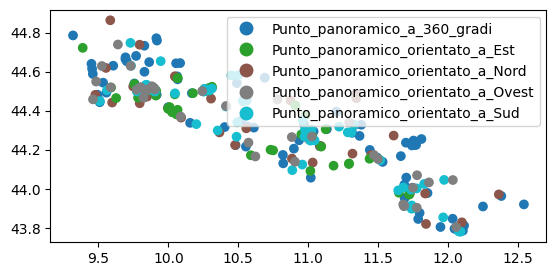

In [48]:
viewpoints_gdf.plot(column='layer', legend=True)

# Preprocessing: viewpoints

In [49]:
dem_bbox = box(dem_bounds.left, dem_bounds.bottom, dem_bounds.right, dem_bounds.top)

# Create a GeoDataFrame with the DEM bounding box
dem_bbox_gdf = gpd.GeoDataFrame([[dem_bbox]], columns=['geometry'], crs=dem_crs)

if viewpoints_gdf.crs != dem_crs:
    viewpoints_gdf = viewpoints_gdf.to_crs(dem_crs)

# Clip the trail network using the DEM bounding box
clipped_viewpoints = gpd.clip(viewpoints_gdf, dem_bbox_gdf)

In [50]:
clipped_viewpoints.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 58 entries, 141 to 237
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   GmlID        58 non-null     object  
 1   OBJECTID     58 non-null     int64   
 2   ID_POI       58 non-null     object  
 3   DESCRIZIONE  58 non-null     object  
 4   layer        58 non-null     object  
 5   geometry     58 non-null     geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 3.2+ KB


<Axes: >

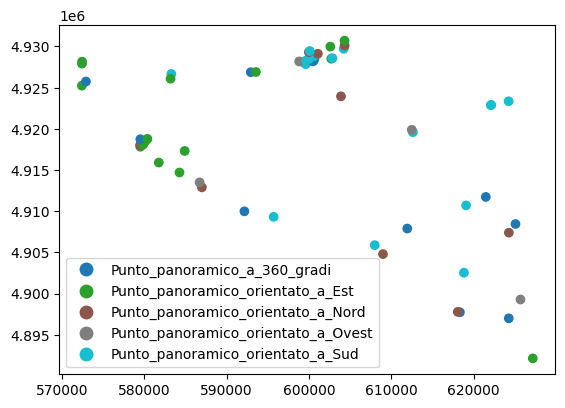

In [51]:
clipped_viewpoints.plot(column='layer', legend=True)

Bar chart: viewpoint orientation categories

<Figure size 1000x600 with 0 Axes>

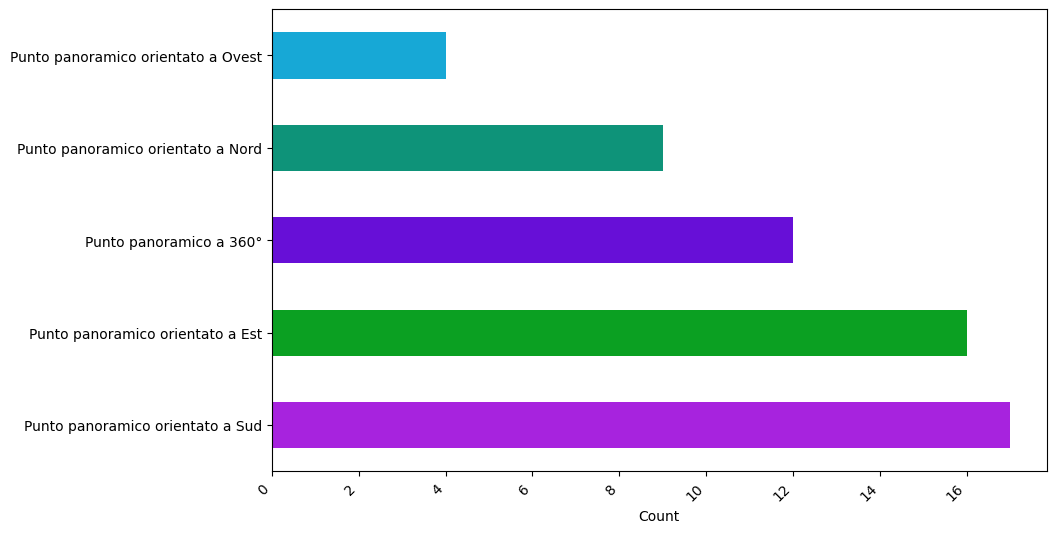

In [52]:
plt.figure(figsize=(10, 6))

category_counts = clipped_viewpoints['DESCRIZIONE'].value_counts()
# random colors for each category
colors = ['#a723de', '#0ba022', '#670fd7', '#0e9379', '#17a8d6']

# Create the bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='barh', color=colors )

plt.xlabel('Count')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')

plt.show()

# Trail with most panoramic viewpoints

In [53]:
def count_viewpoints_near_trail(trail_geom, viewpoints_gdf, buffer_distance=0):
    # Buffer the trail if a buffer distance [m] is provided
    if buffer_distance > 0:
        trail_geom = trail_geom.buffer(buffer_distance)
    # Create a GeoDataFrame from the trail geometry
    trail_gdf = gpd.GeoDataFrame(geometry=[trail_geom], crs=viewpoints_gdf.crs)
    # Spatial join to find viewpoints within the (buffered) trail
    joined = gpd.sjoin(viewpoints_gdf, trail_gdf, how='inner', predicate='within')
    # Return viewpoints near trail
    return joined

# Ensure the coordinate reference systems match
assert clipped_trails.crs == clipped_viewpoints.crs, 'GeoDataFrames must have the same projection!'

# Calculate the viewpoint count for each trail
viewpoint_counts = []
for trail_geom in clipped_trails.geometry:
    viewpoints_on_trail = count_viewpoints_near_trail(trail_geom, clipped_viewpoints, buffer_distance=50)
    viewpoint_counts.append(len(viewpoints_on_trail))

clipped_trails["viewpoint_count"] = viewpoint_counts

In [54]:
max(clipped_trails['viewpoint_count'])
panoramic_trails = clipped_trails[clipped_trails['viewpoint_count'] == max(clipped_trails['viewpoint_count'])]
panoramic_trails

GmlID  OBJECTID  \
1480  Percorso_escursionistico.1552      1552   
1491  Percorso_escursionistico.1563      1563   

                               ID_PERCORSO                    LOCALITA_  \
1480  B40BF2FE-A3F7-4E4A-9128-85DE62F53A90         Sentiero Spallanzani   
1491  B4C257FB-45DC-4AAC-BE9D-6130E94DC726   Moragnano - Pieve di Sasso   

              DIFFICOLTA_ NOME_NUMERO     SIGLA  DISLIVELLO_SALITA  \
1480  E - Escursionistico         SSP  SSPRE-01             9673.0   
1491  E - Escursionistico         763    PR-763              494.0   

      DISLIVELLO_DISCESA  LUNGHEZZA  ... TEMPO_RITORNO CARRABILITA___  \
1480              9082.0   102635.0  ...         42:00                  
1491               642.0     7269.0  ...         03:00           null   

                                                   LINK  \
1480  http://www.appenninoreggiano.it/schede_intro.a...   
1491                                    www.caiparma.it   

                                      LINK_GOOGLE_EARTH  \
1480  https://servizigis.regione.emilia-romagna.it/g...   
1491  https://servizigis.regione.emilia-romagna.it/g...   

                                               geometry        length  \
1480  MULTILINESTRING ((622475.634 4928889.508, 6224...  79837.870336   
1491  LINESTRING (599162.039 4927556.959, 599112.539...   7089.549799   

                                             elevations elevation_gain  \
1480  [506.3, 508.5, 512.3, 512.3, 513.6, 515.4, 516...         6566.7   
1491  [789.5, 793.8, 793.4, 792.9, 797.7, 798.3, 800...          606.0   

      pendenza  viewpoint_count  
1480  8.225044                6  
1491  8.547792                6  

[2 rows x 24 columns]

There are actually two trails with equal number of viewpoints!

In [55]:
# Select them to perform analysis
trail_SSP = panoramic_trails.loc[panoramic_trails.index[0]]
trail_763 = panoramic_trails.loc[panoramic_trails.index[1]]

In [56]:
# Which points ? 
# Reuse the function above, but insted of the whole trail gdf, only on single trail
viewpoints_SSP = count_viewpoints_near_trail(trail_SSP.geometry, clipped_viewpoints, buffer_distance=50)
viewpoints_763 = count_viewpoints_near_trail(trail_763.geometry, clipped_viewpoints, buffer_distance=50)

Plot trails & viewpoints

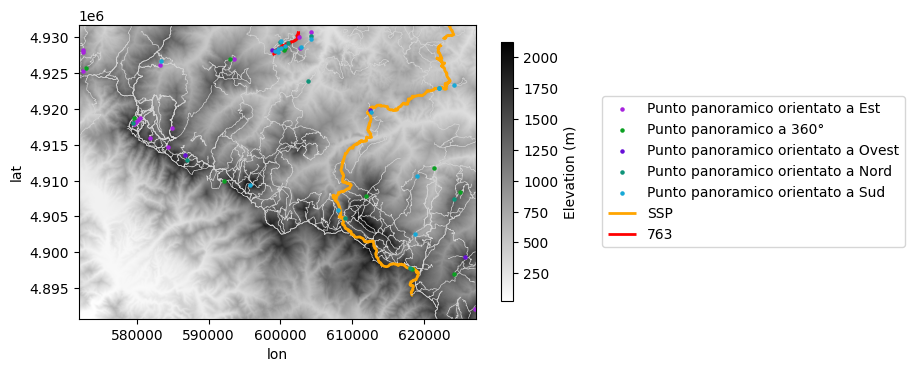

In [57]:
fig, ax = plt.subplots()

plt.imshow(dem_data, zorder=1, cmap='binary', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
plt.colorbar(label='Elevation (m)', shrink=0.7)

# Define a color map for the DESCRIZIONE column
unique_descriptions = clipped_viewpoints['DESCRIZIONE'].unique()
color_map = dict(zip(unique_descriptions, colors)) # use list of colors from bar chart

# Plot viewpoints with different colors based on DESCRIZIONE
for desc in unique_descriptions:
    subset = clipped_viewpoints[clipped_viewpoints['DESCRIZIONE'] == desc]
    subset.plot(ax=ax, zorder=2, color=color_map[desc], markersize=5, label=desc)

clipped_trails.plot(ax=ax, zorder=1, color='lightgray', linewidth=0.5)
# ensure geoseries
gpd.GeoSeries(trail_SSP.geometry).plot(ax=ax, zorder=1, color='orange', linewidth=2, label=f"{trail_SSP['NOME_NUMERO']}")
gpd.GeoSeries(trail_763.geometry).plot(ax=ax, zorder=1, color='red', linewidth=2, label=f"{trail_763['NOME_NUMERO']}")

plt.xlabel('lon')
plt.ylabel('lat')
#plt.title('Panoramic Trails & Viewpoints')
plt.legend(loc='center', bbox_to_anchor=(1.7, 0.5), ncol=1)

# Analysis of Most Panoramic Trail
Now we focus the analysis on the most panoramic trails, which are `trail_763` and `trail_SSP`, two very different trails.

For each trail:
1. what is the elevation profile ?
2. what are the most challenging parts of the trail ? (slope)
3. what is visible from the viewpoints ? (QGIS)


## Graph creation

In [58]:
def series_to_graph(trail, dem_path):
    ''' Create a graph from trail, incorporating elevation from DEM '''
    # Empty graph
    graph = nx.Graph()

    # Add edges to the graph
    edges = multilinestring_to_edges(trail.geometry)
    for edge in edges:
        start = edge[0]
        end = edge[1]
        graph.add_edge(start, end, length=Point(start).distance(Point(end)))

    # Add elevation to each node
    with rasterio.open(dem_path) as src:
        dem_data = src.read(1)
        dem_transform = src.transform

    for node in graph.nodes:
        graph.nodes[node]['elevation'] = extract_elevation(Point(node), dem_data, dem_transform)

    return graph

In [59]:
graph_SSP = series_to_graph(trail_SSP, dem_path)
graph_763 = series_to_graph(trail_763, dem_path)

In [60]:
# Total lenght of trail
def compute_total_trail_length(graph):
    ''' Sums values of length attribute for each edge [m] '''
    total_length = 0
    for u, v, data in graph.edges(data=True):
        total_length += data['length']
    return total_length

total_length_SSP = compute_total_trail_length(graph_SSP)
total_length_763 = compute_total_trail_length(graph_763)

print(f"Total length of trail {trail_SSP['NOME_NUMERO']}: {total_length_SSP*0.001:.2f} km")
print(f"Total length of trail {trail_763['NOME_NUMERO']}: {total_length_763*0.001:.2f} km")

Total length of trail SSP: 79.84 km
Total length of trail 763: 7.09 km


In [61]:
# Average edge lenght (distance between two nodes)
average_length_SSP = total_length_SSP / len(graph_SSP.edges())
average_length_763 = total_length_763 / len(graph_763.edges())

print(f"Average Edge Length of trail {trail_SSP['NOME_NUMERO']}: {average_length_SSP:.2f} m")
print(f"Average Edge Length of trail {trail_763['NOME_NUMERO']}: {average_length_763:.2f} m")

Average Edge Length of trail SSP: 18.68 m
Average Edge Length of trail 763: 15.31 m


In [62]:
list(graph_SSP.nodes)[0]
list(graph_SSP.nodes)[-1]

(623468.7151170777, 4931729.341482854)

In [63]:
def get_ordered_nodes(graph):
    """ Ensure the nodes are ordered based on their positions along the trail """
    # Assuming we start from an arbitrary node, get a linear ordering of the nodes
    start_node = list(graph.nodes)[0]
    ordered_nodes = list(nx.dfs_preorder_nodes(graph, source=start_node))
    return ordered_nodes

In [64]:
def plot_trail_graph(graph, trail_series):
    ''' Plots edged, start node & end node '''
    plt.clf()

    fig, ax = plt.subplots(figsize=(8, 6))

    pos = {node: node for node in graph.nodes()}  # Position nodes using their coordinates 
    edges = graph.edges()

    nx.draw_networkx_edges(graph, pos, edgelist=edges, ax=ax, edge_color='red')

    # Highlight start and end nodes with distinct colors and sizes
    ordered_nodes = get_ordered_nodes(graph)
    start_node = ordered_nodes[0]
    end_node = ordered_nodes[-1]
    nx.draw_networkx_nodes(graph, pos, nodelist=[start_node, end_node], node_size=100, node_color=['green', 'blue'], ax=ax)

    # Add labels to start and end nodes
    labels = {start_node: 'Start', end_node: 'End'}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8, font_color='black', ax=ax)
    plt.title(f"{trail_series['LOCALITA_']} ({trail_series['NOME_NUMERO']})")

    plt.show()

    return fig

<Figure size 640x480 with 0 Axes>

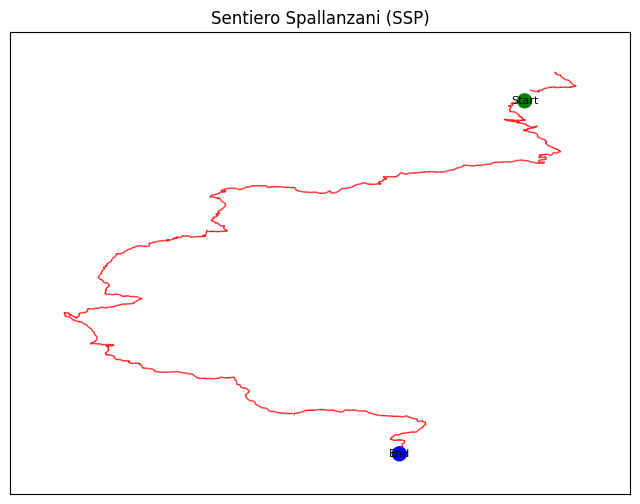

<Figure size 640x480 with 0 Axes>

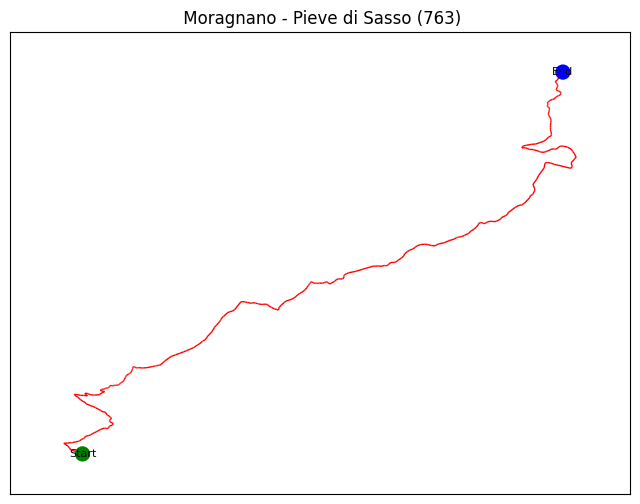

In [65]:
plotSSP = plot_trail_graph(graph_SSP, trail_SSP)
plot763 = plot_trail_graph(graph_763, trail_763)

We can notice that there is a part of the trail SSP disconnected from the rest. Because it is a short portion, I exclude it and create a subgraph with the connected part, which will be used for further analysis.

<Figure size 640x480 with 0 Axes>

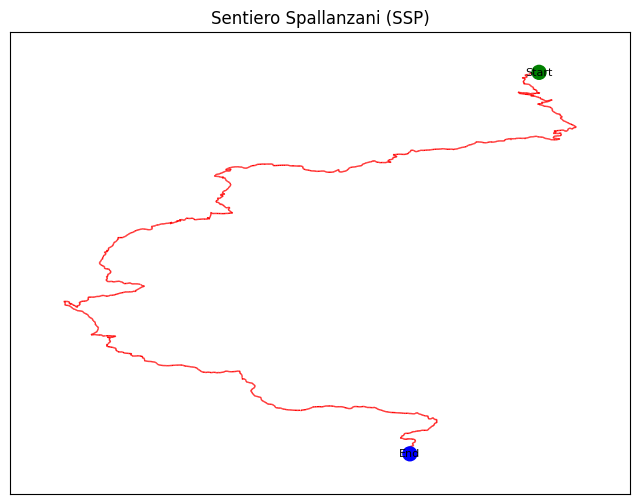

In [66]:
ordered_nodes = get_ordered_nodes(graph_SSP)
graph_SSP_conn = graph_SSP.subgraph(ordered_nodes).copy()
plot_conn = plot_trail_graph(graph_SSP_conn, trail_SSP)

## 1. Elevation profile
Steps to compute an elevation profile:
1. Extract Node Elevations and Distances: traverse the graph and extract the elevations and cumulative distances for each node.
2. Sort Nodes by Distance: Ensure that the nodes are sorted by their cumulative distance along the trail.

In [67]:
def calculate_cumulative_distances(graph, start_node):
    cumulative_distances = {start_node: 0}
    # initialize: list of triples node-elevation-cumulative distance
    elevation_profile = [(start_node, graph.nodes[start_node]['elevation'], 0)]
    visited = set([start_node])
    stack = [start_node]

    while stack:
        node = stack.pop()
        for neighbor in graph.neighbors(node):
            if neighbor not in visited:
                visited.add(neighbor)
                cumulative_distance = cumulative_distances[node] + graph[node][neighbor]['length']
                cumulative_distances[neighbor] = cumulative_distance
                elevation_profile.append((neighbor, graph.nodes[neighbor]['elevation'], cumulative_distance))
                stack.append(neighbor)

    # Sort elevation profile by cumulative distance
    elevation_profile.sort(key=lambda x: x[2])
    return elevation_profile

In [68]:
def plot_elevation_profile(elevation_profile, trail_series):
    plt.clf()

    # Extract distances and elevations 
    distances = [point[2] for point in elevation_profile]
    distances_kilometers = [distance / 1000 for distance in distances]
    elevations = [point[1] for point in elevation_profile]

    plt.figure(figsize=(10, 6))
    plt.plot(distances_kilometers, elevations)
    plt.xlabel('Distance along trail (km)')
    plt.ylabel('Elevation (m)')
    #plt.title(f"Elevation Profile of {trail_series['LOCALITA_']} ({trail_series['NOME_NUMERO']})")
    plt.legend()
    plt.grid()
    plt.show()

    return fig


<Figure size 640x480 with 0 Axes>

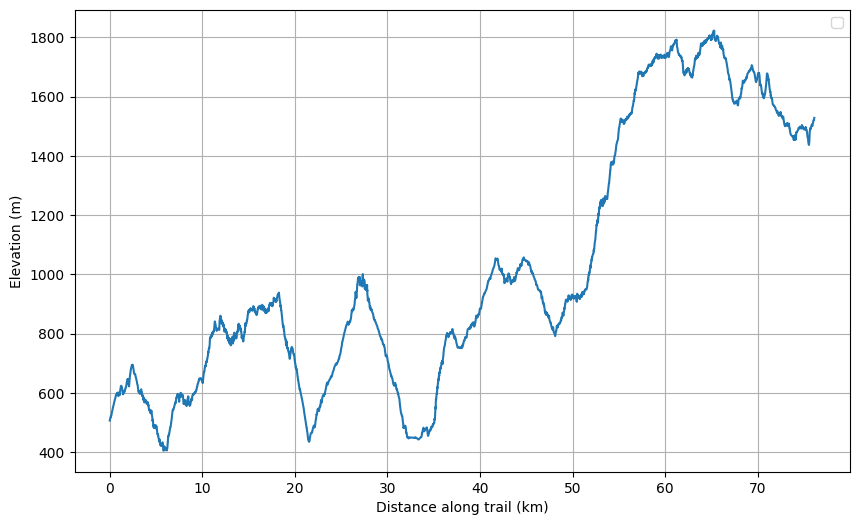

<Figure size 640x480 with 0 Axes>

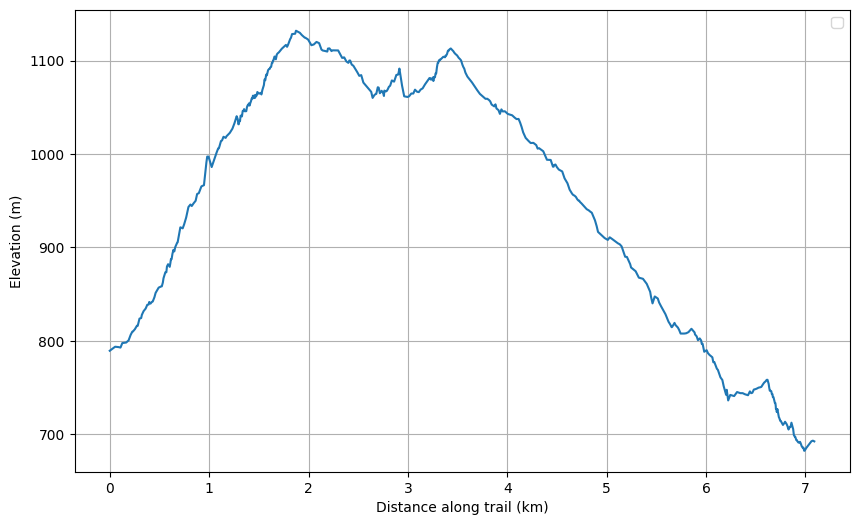

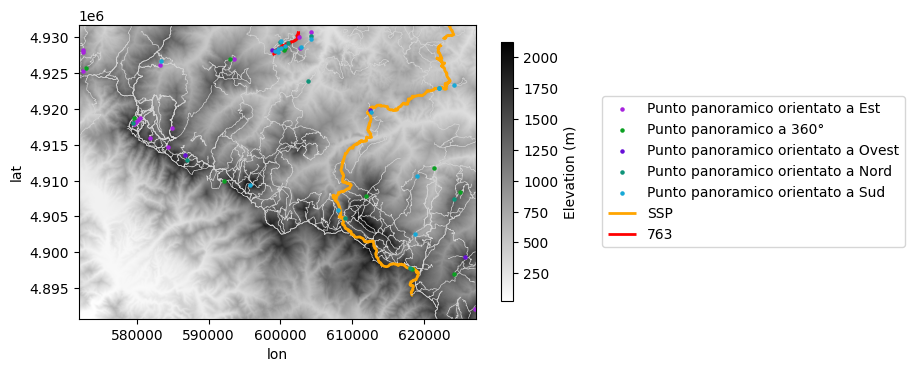

In [69]:
elevation_profile_SSP = calculate_cumulative_distances(graph_SSP_conn, start_node=list(graph_SSP_conn.nodes)[0])
plot_elevation_profile(elevation_profile_SSP, trail_SSP)

elevation_profile_763 = calculate_cumulative_distances(graph_763, start_node=list(graph_763.nodes)[0])
plot_elevation_profile(elevation_profile_763, trail_763)

## 2. Slope and gradient analysis
Compute slope between consecutive nodes: ratio of elevation change to horizontal distance.

Gradient Analysis: Analyze the distribution of gradients along the trail. 
Categorize sections into flat, moderate, and steep based on the gradient.

In [70]:
def add_slopes_to_graph(graph):
    '''  Function to calculate and add slopes to the edges '''

    for u, v, data in graph.edges(data=True):
        elevation_u = graph.nodes[u]['elevation']
        elevation_v = graph.nodes[v]['elevation']
        elevation_change = elevation_v - elevation_u
        horizontal_distance = data['length']
        if horizontal_distance != 0:
            slope = elevation_change / horizontal_distance * 100
        else:
            slope = 0  # Handle the case where distance is zero
        graph[u][v]['slope'] = slope

In [71]:
add_slopes_to_graph(graph_SSP_conn)
add_slopes_to_graph(graph_763)

In [72]:
def categorize_slope(slope):
    ''' Function to categorize slopes '''
    
    if slope < 0:
        return 'downhill'
    if slope < 5:
        return 'flat'
    elif slope < 15:
        return 'moderate'
    else:
        return 'steep'

def collect_count_slopes(graph):
    # Collect slopes and categorize them
    slopes = [data['slope'] for _, _, data in graph.edges(data=True)]
    slope_categories = [categorize_slope(slope) for slope in slopes]
    # Count occurrences of each category
    slope_category_counts = Counter(slope_categories)
    
    return slopes, slope_categories, slope_category_counts

In [73]:
_, _, slope_category_counts_SSP = collect_count_slopes(graph_SSP_conn)
_, _, slope_category_counts_763 = collect_count_slopes(graph_763)

print(f"SSP: {slope_category_counts_SSP}")
print(f"763: {slope_category_counts_763}")

SSP: Counter({'downhill': 1763, 'steep': 1019, 'moderate': 680, 'flat': 634})
763: Counter({'downhill': 209, 'steep': 116, 'flat': 89, 'moderate': 49})


As computed above, the nodes of the graph have an average distance of 18m. This is quite close (dense graph), so it would be a more useful analysis to divide the trail into bigger sections.

In [74]:
def calculate_segment_slope(graph, segment_length):
    ''' Function to calculate average slope for a segment of nodes/edges based on desired segment length '''

    segments = []
    nodes = list(graph.nodes())
    
    i = 0
    while i < len(nodes) - 1:
        segment_nodes = []
        segment_slopes = []
        cumulative_length = 0
        
        # Accumulate nodes and edges until the desired segment length is reached
        while i < len(nodes) - 1 and cumulative_length < segment_length:
            u = nodes[i]
            v = nodes[i + 1]
            if graph.has_edge(u, v):
                edge_length = graph[u][v]['length']
                if cumulative_length + edge_length > segment_length and cumulative_length != 0:
                    break
                cumulative_length += edge_length
                #segment_nodes.append((u, v)) 
                segment_nodes.append(u)
                segment_nodes.append(v) 
                segment_slopes.append(graph[u][v]['slope'])
            i += 1
        
        # Calculate average slope for the segment
        if segment_slopes:
            segment_average = sum(segment_slopes) / len(segment_slopes)
        else:
            segment_average = 0  # case where there are no edges in the segment

        segments.append({'segment_nodes': segment_nodes, 'segment_average': segment_average})

    return segments


In [75]:
# SSP
segment_length = 1000 #[m] 1km
segments_SSP = calculate_segment_slope(graph_SSP_conn, segment_length) # list of dicts, each dict is a segment

segment_averages_SSP = [segment['segment_average'] for segment in segments_SSP]
segment_categories_SSP = [categorize_slope(slope) for slope in segment_averages_SSP]
segment_category_counts_SSP = Counter(segment_categories_SSP)

for category, count in segment_category_counts_SSP.items():
    print(f"{category}: {count}")


moderate: 21
flat: 20
downhill: 29
steep: 8


In [76]:
# Same for 763
segment_length = 1000 #[m] 1km
segments_763 = calculate_segment_slope(graph_763, segment_length) # list of dicts, each dict is a segment

segment_averages_763 = [segment['segment_average'] for segment in segments_763]
segment_categories_763 = [categorize_slope(slope) for slope in segment_averages_763]
segment_category_counts_763 = Counter(segment_categories_763)

for category, count in segment_category_counts_763.items():
    print(f"{category}: {count}")


steep: 2
downhill: 5
flat: 1


Plot slope for segments

In [77]:
def plot_segments_slope(graph, segment_categories, segments, series_trail):

    plt.clf()
    
    # Define colors for each category
    slope_colors = {
        'downhill': 'blue',
        'flat': 'green',
        'moderate': 'yellow',
        'steep': 'red'
    }

    pos = {node: node for node in graph.nodes()}
    
    # Plot segments with corresponding colors
    plt.figure(figsize=(10, 6))
    for i, category in enumerate(segment_categories):
        color = slope_colors[category]

        # Plot segment
        segment_nodes = segments[i]['segment_nodes']
        for u, v in zip(segment_nodes[:-1], segment_nodes[1:]):
            if graph.has_edge(u, v):
                x_coords = [u[0], v[0]]
                y_coords = [u[1], v[1]]
                plt.plot(x_coords, y_coords, color=color, linewidth=2)

    # Plot start and end nodes
    start_node = segments[0]['segment_nodes'][0]
    end_node = segments[-1]['segment_nodes'][-1]

    nx.draw_networkx_nodes(graph, pos, nodelist=[start_node, end_node], node_size=100, node_color=['green', 'blue'])
    # Add labels to start and end nodes
    labels = {start_node: 'Start', end_node: 'End'}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8, font_color='black')

    plt.title(f"Trail {series_trail['NOME_NUMERO']}")
    legend_elements = [
            plt.Line2D([0], [0], color='blue', lw=2, label='Downhill'),
            plt.Line2D([0], [0], color='green', lw=2, label='Flat (<5%)'),
            plt.Line2D([0], [0], color='yellow', lw=2, label='Moderate (<15%)'),
            plt.Line2D([0], [0], color='red', lw=2, label='Steep (>15%)')
        ]
    plt.legend(handles=legend_elements)

    plt.show()

<Figure size 640x480 with 0 Axes>

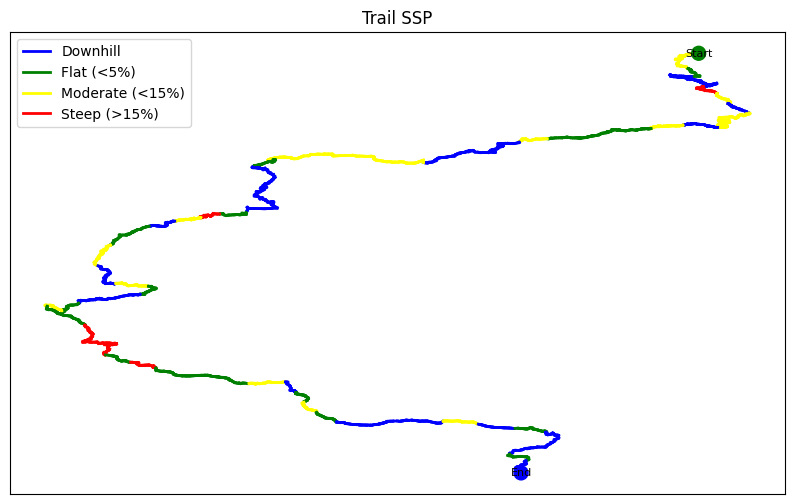

In [78]:
plot_segments_slope(graph_SSP_conn, segment_categories_SSP, segments_SSP, trail_SSP)

<Figure size 640x480 with 0 Axes>

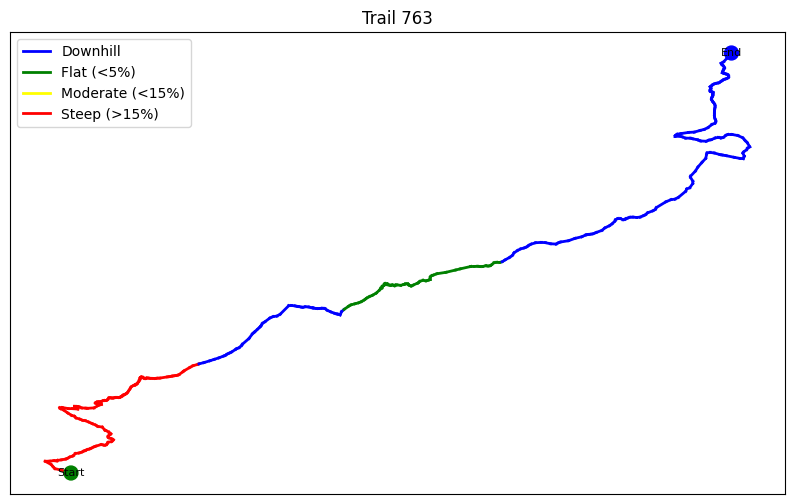

In [79]:
plot_segments_slope(graph_763, segment_categories_763, segments_763, trail_763)

Plot slope for each edge

In [80]:
def plot_edge_slope(graph):
    plt.clf()
    
    slope_colors = {
        'downhill': 'blue',
        'flat': 'green',
        'moderate': 'yellow',
        'steep': 'red',
    }
    pos = {node: node for node in graph.nodes()}

    # Example usage to plot the trail
    plt.figure(figsize=(12, 8))

    # Iterate over edges, categorize by slope, and plot
    for u, v, data in graph.edges(data=True):
        slope = data['slope']
        category = categorize_slope(slope)
        color = slope_colors[category]
        
        # Extract coordinates for plotting
        x_coords = [u[0], v[0]]
        y_coords = [u[1], v[1]]
        
        # Plot edge with corresponding color
        plt.plot(x_coords, y_coords, color=color, linewidth=2)

    start_node = list(graph.nodes)[0]
    end_node = list(graph.nodes)[-1]
    nx.draw_networkx_nodes(graph, pos, nodelist=[start_node, end_node], node_size=100, node_color=['green', 'blue'])
    # Add labels to start and end nodes
    labels = {start_node: 'Start', end_node: 'End'}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8, font_color='black')

    plt.title('Trail with Different Slope Categories')
    plt.show()
    return fig

<Figure size 640x480 with 0 Axes>

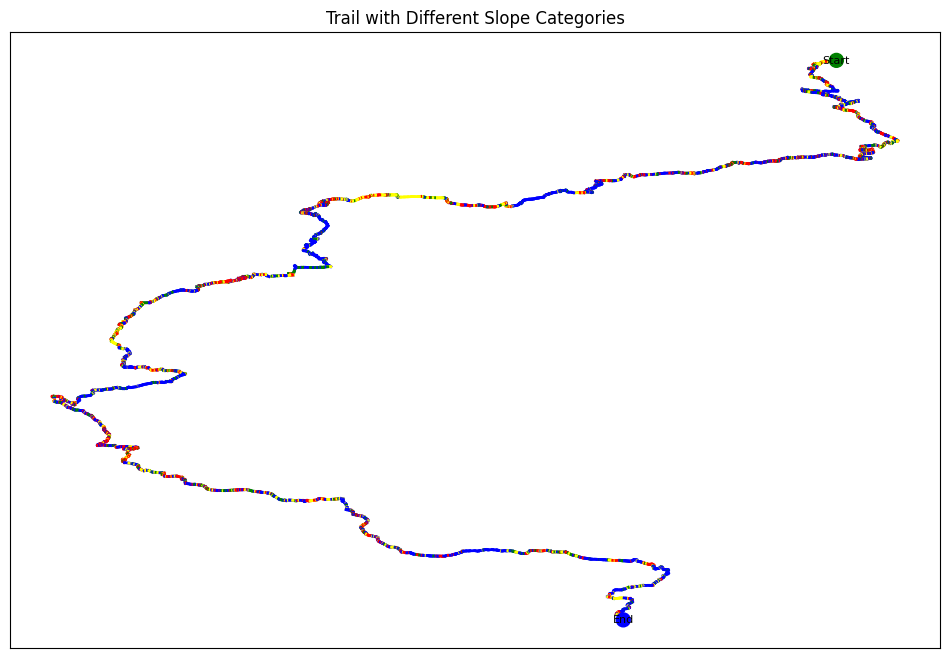

<Figure size 640x480 with 0 Axes>

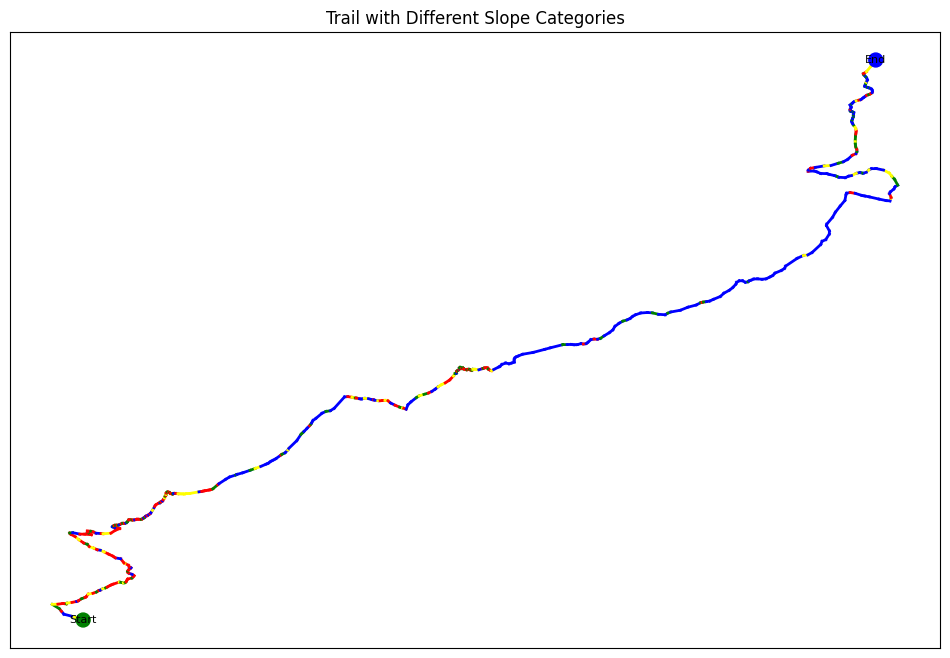

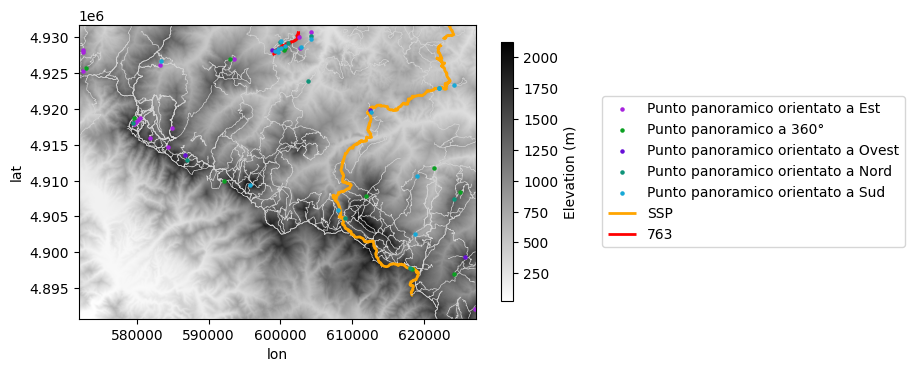

In [81]:
plot_edge_slope(graph_SSP_conn)
plot_edge_slope(graph_763)

## 3. Peaks visible from viewpoints

In [82]:
# I already found the viewpoints on the trail (gdf)
viewpoints_763
viewpoints_SSP

GmlID  OBJECTID  \
76         Punto_panoramico_a_360_gradi.4118      4118   
126   Punto_panoramico_orientato_a_Nord.4119      4119   
117   Punto_panoramico_orientato_a_Nord.2648      2648   
273  Punto_panoramico_orientato_a_Ovest.2961      2961   
243    Punto_panoramico_orientato_a_Sud.4827      4827   
242    Punto_panoramico_orientato_a_Sud.4825      4825   

                                   ID_POI                         DESCRIZIONE  \
76   EB331637-CB95-4301-9457-3F39152BC928             Punto panoramico a 360°   
126  31CEE6FA-7738-440B-A7B6-6131CB58A418   Punto panoramico orientato a Nord   
117  C5B52932-7800-4205-910A-52462CCD371C   Punto panoramico orientato a Nord   
273  20A45971-342B-4385-90B5-973E53F9F33F  Punto panoramico orientato a Ovest   
243  0A0B5190-AFE6-48F5-8F01-574949CC8646    Punto panoramico orientato a Sud   
242  9AF05FEC-D681-4696-9791-790AF9F2AD76    Punto panoramico orientato a Sud   

                                  layer                        geometry  \
76         Punto_panoramico_a_360_gradi  POINT (618309.730 4897733.102)   
126   Punto_panoramico_orientato_a_Nord  POINT (618054.207 4897778.720)   
117   Punto_panoramico_orientato_a_Nord  POINT (608970.068 4904792.367)   
273  Punto_panoramico_orientato_a_Ovest  POINT (612469.109 4919881.525)   
243    Punto_panoramico_orientato_a_Sud  POINT (622065.790 4922867.267)   
242    Punto_panoramico_orientato_a_Sud  POINT (622115.187 4922912.450)   

     index_right  
76             0  
126            0  
117            0  
273            0  
243            0  
242            0

In [84]:
# What are the peaks on the trail?
# I can do the same with the peaks
peaks_path = '../data/peaks_clean.geojson'
peaks_clean = gpd.read_file(peaks_path)

peaks_SSP = count_viewpoints_near_trail(trail_SSP.geometry, peaks_clean, buffer_distance=50)
peaks_SSP

name     ele  ele_dem                        geometry  \
148        Monte San Vitale   863.0    860.1  POINT (622761.171 4922812.617)   
173           Monte Bauzola   837.0    834.7  POINT (621231.214 4922647.713)   
216            Cima la Nuda  1708.0   1702.3  POINT (617624.500 4897844.950)   
217         Colle dei Laghi  1693.0   1683.3  POINT (618326.344 4897733.130)   
218  Alpicella delle Radici  1682.0   1677.4  POINT (618893.581 4897370.057)   
336      Monte delle Forche  1055.0   1051.8  POINT (608650.789 4910981.980)   

     index_right  
148            0  
173            0  
216            0  
217            0  
218            0  
336            0

<Axes: >

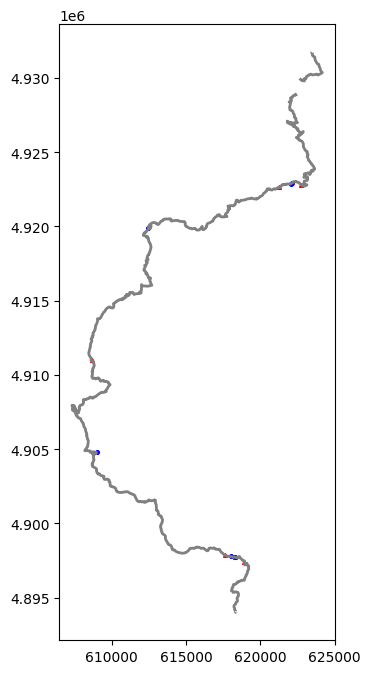

In [85]:
# PLOT TRAIL, VIEWPOINTS AND PEAKS ON TRAIL
fig, ax = plt.subplots(figsize=(10,8))

# ensure max_viewpoints is a geoseries
gpd.GeoSeries(trail_SSP.geometry).plot(ax=ax, color='gray', linewidth=2)

peaks_SSP.plot(ax=ax, color='red', marker='^', markersize=7)
viewpoints_SSP.plot(ax=ax, color='blue', markersize=7)

## Intervisibility Analysis: save data for QGIS
- **DEM** : ready (data/tinitaly_dem.tif)
- **mountain peaks** : ready (data/peaks_clean.json)
- **viewpoints** : save `viewpoints_763` and `viewpoints_SSP` separately
- **trails**: save `panoramic_trails` (SSP and 763)

In [86]:
# Save viewpoints & trail
viewpoints_763.to_file('../qgis_analysis/qgis_layers/viewpoints_763.geojson', driver='GeoJSON')
viewpoints_SSP.to_file('../qgis_analysis/qgis_layers/viewpoints_SSP.geojson', driver='GeoJSON')

# remove elevation column (list) and save (not needed in QGIS)
panoramic_trails.pop('elevations')
panoramic_trails.to_file('../qgis_analysis/qgis_layers/panoramic_trails.geojson', driver='GeoJSON')

clipped_trails.pop('elevations')
clipped_trails.to_file('../data/clipped_trails.geojson', driver='GeoJSON')